## Detecting if a person is homeless or not

## Installing packages and API call

In [237]:
# !pip install --upgrade google-api-python-client google-auth-httplib2 google-auth-oauthlib
# !pip install gspread

In [337]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import math
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import KMeans
from googleapiclient.discovery import build
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
from sklearn.metrics import silhouette_score
import pickle
import os.path
import gspread
from google.oauth2.service_account import Credentials

In [239]:
def get_data_google_sheets(sample_spreadsheet_id, tab_index):
    
    # Link to authenticate 
    scopes = [
        'https://www.googleapis.com/auth/spreadsheets',
        'https://www.googleapis.com/auth/drive'
        ]

    # Read the .json file and authenticate with the links
    credentials = Credentials.from_service_account_file(
            'authentication-340508-a97ec308e163.json',
            scopes=scopes
        )
    
    # Request authorization and open the selected spreadsheet
    gc = gspread.authorize(credentials).open_by_key(sample_spreadsheet_id)

    # Prompts for all spreadsheet values
    values = gc.get_worksheet(tab_index).get_all_values()
    
    # Turns the return into a dataframe
    df = pd.DataFrame(values)
    df.columns = df.iloc[0]
    df.drop(df.index[0], inplace=True)         

    return df

In [240]:
form = get_data_google_sheets("1MHB_pqmK1d8fyGTNTdDth4EKcY3zHWw_zuGZo1SqR3g", 0 )
form.head()

,Timestamp,disability,stayed_in_emergency_shelter,minority,hospitalized_due_to_malnutrition,marital_status,Gender,num_shelters_year,years_not_in_residence,Age,num_times_relocated_mont,days_since_hot_meal,num_dependents,avg_meal_per_day
1,06/02/2022 00:11:18,yes,no,yes,no,single,female,12,3,25,25,300,2,0
2,06/02/2022 01:27:48,yes,yes,yes,yes,single,female,3,4,28,8,180,1,1
3,06/02/2022 01:34:58,yes,yes,yes,yes,single,other,2,0.6,23,10,36,0,1
4,06/02/2022 01:45:41,no,no,no,no,single,male,0,0,21,0,1,0,3


In [241]:
form = form.drop('Timestamp',1)

/tmp/ipykernel_585/1773784532.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  form = form.drop('Timestamp',1)


In [242]:
form

,disability,stayed_in_emergency_shelter,minority,hospitalized_due_to_malnutrition,marital_status,Gender,num_shelters_year,years_not_in_residence,Age,num_times_relocated_mont,days_since_hot_meal,num_dependents,avg_meal_per_day
1,yes,no,yes,no,single,female,12,3,25,25,300,2,0
2,yes,yes,yes,yes,single,female,3,4,28,8,180,1,1
3,yes,yes,yes,yes,single,other,2,0.6,23,10,36,0,1
4,no,no,no,no,single,male,0,0,21,0,1,0,3


## Generating synthetic data for testing and training

In [243]:
df = pd.DataFrame()
anom = pd.DataFrame()
test = pd.DataFrame()

In [244]:
gender = ["male", "female", "other"]
binary = ["yes", "no"]
marital_status = ["single", "married"]

In [245]:
# df.loc[:,'disability'] = [random.choice(binary) for i in range(8000)]
# df.loc[:,'stayed_in_emergency_shelter'] = [random.choice(binary) for i in range(8000)]
# df.loc[:,'minority'] = [random.choice(binary) for i in range(1000)]
# df.loc[:,'hospitalized_due_to_malnutrition'] = [random.choice(binary) for i in range(8000)]
# df.loc[:,'marital_status'] = [random.choice(marital_status) for i in range(8000)]
# df.loc[:,'Gender'] = [random.choice(gender) for i in range(8000)]

# df.loc[:,'num_shelters_year'] = [random.randint(1, 10) for i in range(8000)]
# df.loc[:,'years_not_in_residence'] = [random.randint(0, 15) for i in range(8000)]
# df.loc[:,'Age'] = [random.randint(18, 65) for i in range(1000)]
# df.loc[:,'num_times_relocated_month'] = [random.randint(4, 20) for i in range(8000)]
# df.loc[:,'days_since_hot_meal'] = [random.randint(30, 600) for i in range(8000)]
# df.loc[:,'num_dependents'] = [random.randint(0, 3) for i in range(8000)]
# df.loc[:,'avg_meal_per_day'] = [random.randint(0, 1) for i in range(8000)]

In [246]:
random.seed(10)
df.loc[:,'disability'] = [random.choice(binary) for i in range(8000)]
df.loc[:,'stayed_in_emergency_shelter'] = [random.choice(binary) for i in range(8000)]
df.loc[:,'minority'] = [random.choice(binary) for i in range(8000)]
df.loc[:,'hospitalized_due_to_malnutrition'] = [random.choice(binary) for i in range(8000)]
df.loc[:,'marital_status'] = [random.choice(marital_status) for i in range(8000)]
df.loc[:,'Gender'] = [random.choice(gender) for i in range(8000)]

df.loc[:,'num_shelters_year'] = [random.randint(1, 10) for i in range(8000)]
df.loc[:,'years_not_in_residence'] = [random.randint(1, 15) for i in range(8000)]
df.loc[:,'Age'] = [random.randint(18, 65) for i in range(8000)]
df.loc[:,'num_times_relocated_month'] = [random.randint(4, 20) for i in range(8000)]
df.loc[:,'days_since_hot_meal'] = [random.randint(30, 600) for i in range(8000)]
df.loc[:,'num_dependents'] = [random.randint(0, 3) for i in range(8000)]
df.loc[:,'avg_meal_per_day'] = [random.randint(0, 1) for i in range(8000)]


anom.loc[:,'disability'] = [random.choice(binary) for i in range(1000)]
anom.loc[:,'stayed_in_emergency_shelter'] = [random.choice(binary) for i in range(1000)]
anom.loc[:,'minority'] = [random.choice(binary) for i in range(1000)]
anom.loc[:,'hospitalized_due_to_malnutrition'] = [random.choice(binary) for i in range(1000)]
anom.loc[:,'marital_status'] = [random.choice(marital_status) for i in range(1000)]
anom.loc[:,'Gender'] = [random.choice(gender) for i in range(1000)]

shelter = [0, 20, 10, 30, 50]
relocate = [0,1,2,3,20,21,30,100]
anom.loc[:,'num_shelters_year'] = [random.choice(shelter) for i in range(1000)]
anom.loc[:,'years_not_in_residence'] = [random.randint(0, 15) for i in range(1000)]
anom.loc[:,'Age'] = [random.randint(12, 65) for i in range(1000)]
anom.loc[:,'num_times_relocated_month'] = [random.choice(relocate) for i in range(1000)]
anom.loc[:,'days_since_hot_meal'] = [random.randint(0, 14) for i in range(1000)]
anom.loc[:,'num_dependents'] = [random.randint(0, 6) for i in range(1000)]
anom.loc[:,'avg_meal_per_day'] = [random.randint(1, 4) for i in range(1000)]


test.loc[:,'disability'] = [random.choice(binary) for i in range(2000)]
test.loc[:,'stayed_in_emergency_shelter'] = [random.choice(binary) for i in range(2000)]
test.loc[:,'minority'] = [random.choice(binary) for i in range(2000)]
test.loc[:,'hospitalized_due_to_malnutrition'] = [random.choice(binary) for i in range(2000)]
test.loc[:,'marital_status'] = [random.choice(marital_status) for i in range(2000)]
test.loc[:,'Gender'] = [random.choice(gender) for i in range(2000)]

test.loc[:,'num_shelters_year'] = [random.randint(0, 20) for i in range(2000)]
test.loc[:,'years_not_in_residence'] = [random.randint(0, 15) for i in range(2000)]
test.loc[:,'Age'] = [random.randint(18, 65) for i in range(2000)]
test.loc[:,'num_times_relocated_month'] = [random.randint(0, 100) for i in range(2000)]
test.loc[:,'days_since_hot_meal'] = [random.randint(0, 600) for i in range(2000)]
test.loc[:,'num_dependents'] = [random.randint(0, 6) for i in range(2000)]
test.loc[:,'avg_meal_per_day'] = [random.randint(1, 4) for i in range(2000)]

In [247]:
test

,disability,stayed_in_emergency_shelter,minority,hospitalized_due_to_malnutrition,marital_status,Gender,num_shelters_year,years_not_in_residence,Age,num_times_relocated_month,days_since_hot_meal,num_dependents,avg_meal_per_day
0,no,yes,yes,yes,single,female,14,11,60,93,182,1,1
1,no,yes,no,yes,single,female,12,7,29,40,405,4,3
2,no,yes,no,no,single,female,15,0,57,77,327,1,4
3,no,no,no,yes,single,male,19,11,64,99,151,3,3
4,yes,no,no,yes,single,male,18,3,38,85,206,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,no,no,no,no,single,male,10,6,51,22,223,4,2
1996,no,yes,no,no,married,male,13,1,27,51,337,0,2
1997,yes,yes,yes,no,married,female,10,7,63,87,308,1,2
1998,no,yes,yes,no,married,other,13,5,64,63,439,5,2


In [248]:
df = pd.concat([df, anom])

In [249]:
dict = {'num_shelters_year': 0, 
        'years_not_in_residence': 0, 
        'Age': 20,
        'Gender': 'male',
        'num_times_relocated_month': 0,
        'days_since_hot_meal': 0,
        'num_dependents': 0,
        'marital_status': 'single',
        'disability': 'no',
        'stayed_in_emergency_shelter': 'no',
        'minority': 'no',
        'hospitalized_due_to_malnutrition': 'no',
        'avg_meal_per_day': 3
       }

df = df.append(dict, ignore_index = True)

In [250]:
dict = {'num_shelters_year': 6, 
        'years_not_in_residence': 6, 
        'Age': 20,
        'Gender': 'male',
        'num_times_relocated_month': 1,
        'days_since_hot_meal': 1,
        'num_dependents': 2,
        'marital_status': 'single',
        'disability': 'no',
        'stayed_in_emergency_shelter': 'yes',
        'minority': 'yes',
        'hospitalized_due_to_malnutrition': 'no',
        'avg_meal_per_day': 1
       }

df = df.append(dict, ignore_index = True)

In [251]:
df

,disability,stayed_in_emergency_shelter,minority,hospitalized_due_to_malnutrition,marital_status,Gender,num_shelters_year,years_not_in_residence,Age,num_times_relocated_month,days_since_hot_meal,num_dependents,avg_meal_per_day
0,yes,no,yes,no,single,other,4,10,45,7,392,3,1
1,no,yes,yes,no,married,female,1,8,30,9,181,2,1
2,no,yes,no,yes,married,other,7,6,45,4,65,0,1
3,yes,no,yes,no,single,female,10,1,47,4,474,3,1
4,yes,yes,yes,no,married,female,10,4,48,17,431,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8997,no,yes,yes,no,single,other,0,5,32,0,5,4,1
8998,yes,yes,no,yes,single,female,50,7,37,21,12,2,1
8999,yes,yes,yes,yes,single,male,0,12,63,30,5,4,4
9000,no,no,no,no,single,male,0,0,20,0,0,0,3


In [252]:
df.to_csv('synthetic_data.csv')

In [253]:
df2 = pd.read_csv('synthetic_data.csv')

In [254]:
df2 = df2.drop(['Unnamed: 0'], 1)

/tmp/ipykernel_585/2152106489.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df2 = df2.drop(['Unnamed: 0'], 1)


In [255]:
df2_label = df2.copy()

In [256]:
df2.isnull().sum()

disability                          0
stayed_in_emergency_shelter         0
minority                            0
hospitalized_due_to_malnutrition    0
marital_status                      0
Gender                              0
num_shelters_year                   0
years_not_in_residence              0
Age                                 0
num_times_relocated_month           0
days_since_hot_meal                 0
num_dependents                      0
avg_meal_per_day                    0
dtype: int64

## Encoding categorical variables

In [257]:
from sklearn import preprocessing 
label = preprocessing.LabelEncoder() 
 
df2['Gender']= label.fit_transform(df2['Gender']) 
df2['marital_status']= label.fit_transform(df2['marital_status']) 
df2['disability']= label.fit_transform(df2['disability']) 
df2['stayed_in_emergency_shelter']= label.fit_transform(df2['stayed_in_emergency_shelter']) 
df2['minority']= label.fit_transform(df2['minority']) 
df2['hospitalized_due_to_malnutrition']= label.fit_transform(df2['hospitalized_due_to_malnutrition']) 

test['Gender']= label.fit_transform(test['Gender']) 
test['marital_status']= label.fit_transform(test['marital_status']) 
test['disability']= label.fit_transform(test['disability']) 
test['stayed_in_emergency_shelter']= label.fit_transform(test['stayed_in_emergency_shelter']) 
test['minority']= label.fit_transform(test['minority']) 
test['hospitalized_due_to_malnutrition']= label.fit_transform(test['hospitalized_due_to_malnutrition'])

form['Gender']= label.fit_transform(form['Gender']) 
form['marital_status']= label.fit_transform(form['marital_status']) 
form['disability']= label.fit_transform(form['disability']) 
form['stayed_in_emergency_shelter']= label.fit_transform(form['stayed_in_emergency_shelter']) 
form['minority']= label.fit_transform(form['minority']) 
form['hospitalized_due_to_malnutrition']= label.fit_transform(form['hospitalized_due_to_malnutrition'])



In [258]:
test['Gender'].unique()

array([0, 1, 2])

In [259]:
test

,disability,stayed_in_emergency_shelter,minority,hospitalized_due_to_malnutrition,marital_status,Gender,num_shelters_year,years_not_in_residence,Age,num_times_relocated_month,days_since_hot_meal,num_dependents,avg_meal_per_day
0,0,1,1,1,1,0,14,11,60,93,182,1,1
1,0,1,0,1,1,0,12,7,29,40,405,4,3
2,0,1,0,0,1,0,15,0,57,77,327,1,4
3,0,0,0,1,1,1,19,11,64,99,151,3,3
4,1,0,0,1,1,1,18,3,38,85,206,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0,0,0,0,1,1,10,6,51,22,223,4,2
1996,0,1,0,0,0,1,13,1,27,51,337,0,2
1997,1,1,1,0,0,0,10,7,63,87,308,1,2
1998,0,1,1,0,0,2,13,5,64,63,439,5,2


## Training an Isolation Forest

In [260]:
iForest = IsolationForest(n_estimators=20, max_samples='auto', contamination=float(.05),
                          bootstrap=True, n_jobs=-1, random_state=42, verbose=1)
iForest.fit(df2)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(bootstrap=True, contamination=0.05, n_estimators=20, n_jobs=-1,
                random_state=42, verbose=1)

In [261]:
with open('IFmodel.pkl','wb') as f:
    pickle.dump(iForest,f)

In [262]:
df2['scores']=iForest.decision_function(df2)

In [263]:
df2['anomaly']=iForest.predict(df2.iloc[:,:13])

In [345]:
silhouette_score(df2.iloc[:,:13], df2.anomaly, metric='euclidean', sample_size=None, random_state=None)

0.18955705054364752

## Scoring the model

In [264]:
df2.loc[df2['anomaly'] == 1,'anomaly'] = 0
df2.loc[df2['anomaly'] == -1,'anomaly'] = 1
df2['anomaly'].value_counts()

0    8551
1     451
Name: anomaly, dtype: int64

In [265]:
df2[df2['anomaly'] == 1].head(5)

,disability,stayed_in_emergency_shelter,minority,hospitalized_due_to_malnutrition,marital_status,Gender,num_shelters_year,years_not_in_residence,Age,num_times_relocated_month,days_since_hot_meal,num_dependents,avg_meal_per_day,scores,anomaly
8003,0,0,1,0,0,1,10,8,28,20,4,4,4,-0.014983,1
8007,1,0,0,0,0,2,30,13,62,0,0,6,2,-0.016672,1
8010,0,0,0,1,1,0,30,9,30,1,14,6,4,-0.034223,1
8014,0,1,0,0,1,2,50,1,12,0,1,0,2,-0.048237,1
8015,0,1,0,1,0,2,20,0,12,21,0,4,4,-0.033910,1


## Decoding the categorical variables

In [266]:
# def encode(x):
#     if x == 0:
#         x = 'yes'
#         return  x
#     else:
#         x = 'no'
#         return x
    
# def marital_encode(x):
#     if x == 0:
#         x = 'single'
#         return  x
#     else:
#         x = 'married'
#         return x
    
# def gender_encode(x):
#     if x == 0:
#         x = 'male'
#         return  x
#     elif x == 'female':
#         x = 'female'
#         return x
#     elif x == 'other':
#         return x
    
# def anomaly_encode(x):
#     if x == 0:
#         x = 'legit'
#         return  x
#     elif x == 1:
#         x = 'not legit'
#         return x
    
# def encoding(df):        
#     df['disability'] = df['disability'].apply(lambda x:encode(x))
#     df['minority'] = df['minority'].apply(lambda x:encode(x))
#     df['stayed_in_emergency_shelter'] = df['stayed_in_emergency_shelter'].apply(lambda x:encode(x))
#     df['hospitalized_due_to_malnutrition'] = df['hospitalized_due_to_malnutrition'].apply(lambda x:encode(x))
#     df['Gender'] = df['Gender'].apply(lambda x:gender_encode(x))
#     df['marital_status'] = df['marital_status'].apply(lambda x:marital_encode(x))
#     df['anomaly'] = df['anomaly'].apply(lambda x:anomaly_encode(x))
#     return df
    
# encoding(df2)

## Predicting a new observation

In [267]:
def load_model(filename):
    with open(filename, 'rb') as f:
        clf = pickle.load(f)
    return clf

In [270]:
model = load_model('IFmodel.pkl')
form['anomaly'] = model.predict(form.iloc[:,:13])
form.loc[form['anomaly'] == 1,'anomaly'] = 0
form.loc[form['anomaly'] == -1,'anomaly'] = 1
form['anomaly'].value_counts()

/opt/conda/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- num_times_relocated_mont
Feature names seen at fit time, yet now missing:
- num_times_relocated_month

  warnings.warn(message, FutureWarning)


0    3
1    1
Name: anomaly, dtype: int64

In [272]:
# encoding(form)
form[form['anomaly'] == 1].head(5) # not legit

,disability,stayed_in_emergency_shelter,minority,hospitalized_due_to_malnutrition,marital_status,Gender,num_shelters_year,years_not_in_residence,Age,num_times_relocated_mont,days_since_hot_meal,num_dependents,avg_meal_per_day,anomaly
4,0,0,0,0,0,1,0,0,21,0,1,0,3,1


## PCA

In [279]:
from sklearn.preprocessing import StandardScaler

# Separating out the features
x = df2.iloc[:, :13].values
# Separating out the target
y = df2.loc[:,['anomaly']].values
# Standardizing the features
x = StandardScaler().fit_transform(x)

In [280]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [281]:
finalDf = pd.concat([principalDf, df2[['anomaly']]], axis = 1)

In [331]:
finalDf

,principal component 1,principal component 2,anomaly
0,-0.181227,0.348109,0
1,0.111875,-0.628392,0
2,0.076807,0.441444,0
3,0.044817,1.021296,0
4,-0.460649,-0.034013,0
...,...,...,...
8997,0.839052,0.537690,0
8998,3.906467,-0.744687,0
8999,3.361717,0.302356,1
9000,1.125711,-0.003744,1


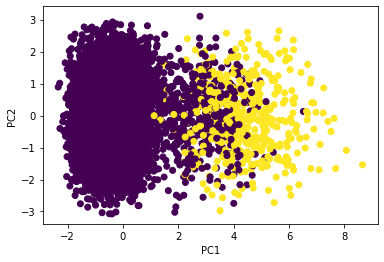

In [334]:
plt.scatter(finalDf.iloc[:,0], finalDf.iloc[:,1],  c = finalDf['anomaly'])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [ ]:
## need to find more ways to reduce false positives

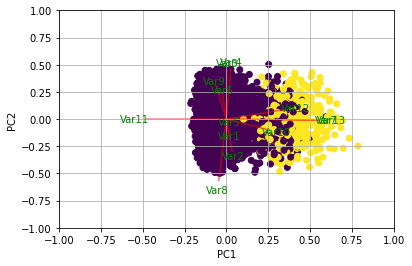

In [330]:
#Create the biplot function
def biplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley, c = y)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.grid()


#Call the function. Use only the 2 PCs.
biplot(principalComponents[:,0:2],np.transpose(pca.components_[0:2, :]))
plt.show()
           
           